讓我們回顧一下生命中第一個做出來的神經網路...

## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Keras functions
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

讀取 MNIST 手寫辨識資料

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [6]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [7]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

## 2. Model Functional API

在此之前，我們使用 Sequential 便足以建構大多數的神經網路，那是因為我們接觸的神經網路多為線性堆疊 (linear stack)。

除了輸入層需指定 input_dim 外，其餘隱藏層只需宣告，那是因為 Sequential 會認定上一層的輸出這一層的輸入。

因此，再建構線性堆疊的神經網路時，Sequential 便足以處理。

### 2.1 Functional API 的使用時機

當神經網路模型為非線性的複雜網路結構，如：

* 多重輸出-多重輸入模型 (Multi-input and multi-output models)
    * 分歧 (branch)
    * 合併 (merge)
* 具重複/循環結構的模型，如: CycleGAN

Sequential 便不足以建構這類複雜結構的神經網路，我們以下介紹 Model Fnuctional API 的使用。

首先，我們先將 Model 引入。

In [9]:
from keras.models import Model

在 Model 的世界中，所有的神經網路層 (fully-connected, convolution, MaxPooling, LSTM, etc) 都被視作函數來操作，因此，我們只需關心函數的輸入和輸出即可。

此外，為了讓神經網路的第一層從不需要輸入 input_dim，我們還需引進下面這個函數來代替 input_dim。 (此寫法亦可用在 Sequential)

In [10]:
from keras.layers import Input

### 2.2 Functional API 的函數概念

回顧一下，我們想學習的手寫辨識模型是一個長得像這樣的函數

我們希望建立一個具有兩個隱藏層的神經網路來學習這個函數，攤開來看的話，如下：

或是以簡易的圖來表示這個全連接神經網路
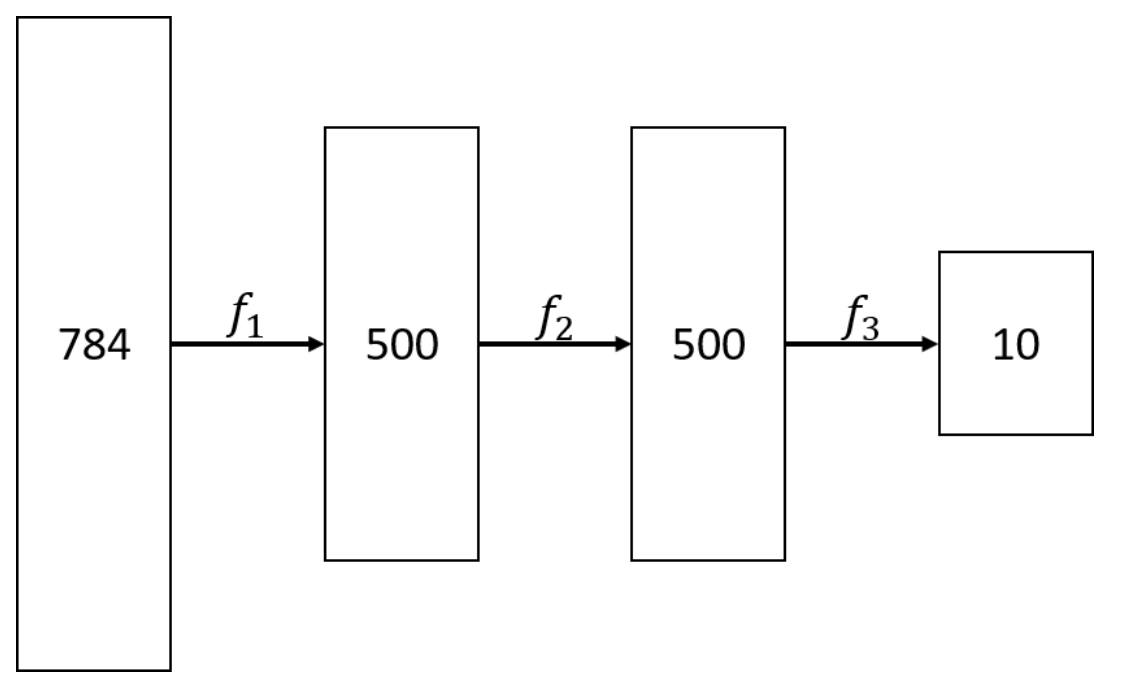

其中，$f_1, f_2, f_3$ 代表的是全連結層所代表的函數，其他變數說明如下：

* $x$: 代表的是輸入模型的圖片向量，為 784 維的向量。
* $h_1$: $x$ 經過第一層隱藏層運算後得結果，即為 $f_1(x)$，為 500 維的向量。
* $h_2$: $h_1$ 經過第二層隱藏層運算後得結果，即為 $f_2(h_1)$，為 500 維的向量。
* $y$: $h_2$ 經過最後一層運算後得結果，即為 $f_3(h_2)$，為 10 維的向量，代表的是 $x$ 為哪個數字的機率。

注意: 為了方便，我們將 Dense(500), Activation('sigmoid') 兩個合併用 Dense(500, activation='sigmoid') 表示

### 2.3 Functional API 的操作方式

我們沿用上圖的變數名稱來定義

In [13]:
f_1 = Dense(500, activation='sigmoid')
f_2 = Dense(500, activation='sigmoid')
f_3 = Dense(10, activation='softmax')

In [14]:
print(f_1)

接著，定義層前後變數之間的關係；首先，第一個變數必定以 Input 函數來定義

In [15]:
x = Input(shape=(784,))

In [17]:
print(x)

Tensor("input_1:0", shape=(?, 784), dtype=float32)


剩下的部分，就如變數說明，幾乎可以照著數學式輸入

$$h_1 = f_1(x), h_2 = f_2(h_1), y = f_3(h_2)$$

In [19]:
h_1 = f_1(x)
h_2 = f_2(h_1)
y = f_3(h_2)

In [20]:
print(h_1)
print(h_2)
print(y)

Tensor("dense_1_1/Sigmoid:0", shape=(?, 500), dtype=float32)
Tensor("dense_2_1/Sigmoid:0", shape=(?, 500), dtype=float32)
Tensor("dense_3_1/Softmax:0", shape=(?, 10), dtype=float32)


In [21]:
model = Model(x, y)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [26]:
model.load_weights('weights.h5')
model.compile(loss='mse', optimizer=SGD(lr=0.1), metrics = ['accuracy'])

In [27]:
score = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 49us/step


In [28]:
print('MSE:%f, Accuracy rate:%f' %(score[0],score[1]))

MSE:0.010594, Accuracy rate:0.934500


### 2.4 小結論

Functional API 的操作流程如下：

1. 將層定義成明確的函數
2. 透過層函數將變數連接
3. 定義神經網路的輸入與輸出